##  Exercici 1

Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

El dataset es un conjunto de datos para predecir el costo médico.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# Configuracion para que se mestren todas las columnas
pd.set_option('display.max_columns', None)
# Configuracion para que los valores no se muestren con punto flotante
pd.options.display.float_format = '{:,.2f}'.format
# Lectura del fichero
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,"16,884.92"
1,18,male,33.77,1,no,southeast,"1,725.55"
2,28,male,33.00,3,no,southeast,"4,449.46"
3,33,male,22.70,0,no,northwest,"21,984.47"
4,32,male,28.88,0,no,northwest,"3,866.86"


Tenemos como feature la edad, el sexo, el indice de masa corporal, cantidad de hijos, si es fumador, recion y los costos.

In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

No tenemos datos vacios.

In [5]:
df.select_dtypes(include=['object', 'category']).columns.to_list()

['sex', 'smoker', 'region']

Tenemos 3 variables categóricas, vamos a transformarlas.

In [6]:
X_train_transformed  = pd.get_dummies(df, prefix=['smoker'], columns=['smoker'])
X_train_transformed = pd.get_dummies(X_train_transformed, prefix=['sex'], columns=['sex'])
X_train_transformed = pd.get_dummies(X_train_transformed, prefix=['region'], columns=['region'])

In [7]:
X_train_transformed.corr()

,age,bmi,children,charges,smoker_no,smoker_yes,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
age,1.00,0.11,0.04,0.30,0.03,-0.03,0.02,-0.02,0.00,-0.00,-0.01,0.01
bmi,0.11,1.00,0.01,0.20,-0.00,0.00,-0.05,0.05,-0.14,-0.14,0.27,-0.01
children,0.04,0.01,1.00,0.07,-0.01,0.01,-0.02,0.02,-0.02,0.02,-0.02,0.02
charges,0.30,0.20,0.07,1.00,-0.79,0.79,-0.06,0.06,0.01,-0.04,0.07,-0.04
smoker_no,0.03,-0.00,-0.01,-0.79,1.00,-1.00,0.08,-0.08,-0.00,0.04,-0.07,0.04
smoker_yes,-0.03,0.00,0.01,0.79,-1.00,1.00,-0.08,0.08,0.00,-0.04,0.07,-0.04
sex_female,0.02,-0.05,-0.02,-0.06,0.08,-0.08,1.00,-1.00,0.00,0.01,-0.02,0.00
sex_male,-0.02,0.05,0.02,0.06,-0.08,0.08,-1.00,1.00,-0.00,-0.01,0.02,-0.00
region_northeast,0.00,-0.14,-0.02,0.01,-0.00,0.00,0.00,-0.00,1.00,-0.32,-0.35,-0.32
region_northwest,-0.00,-0.14,0.02,-0.04,0.04,-0.04,0.01,-0.01,-0.32,1.00,-0.35,-0.32


Nuestra variable objetivo es charges. Podemos ver que hay una correlacion principalmente con smoker_yes, smoker_no, un poco con bmi y age.

Ya podemos preparar nuestro pipeline, en el mismo haremos la transformacion de la variable categórica y normalizacion de las variables numéricas.

In [8]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,"16,884.92"
1,18,male,33.77,1,no,southeast,"1,725.55"
2,28,male,33.00,3,no,southeast,"4,449.46"
3,33,male,22.70,0,no,northwest,"21,984.47"
4,32,male,28.88,0,no,northwest,"3,866.86"


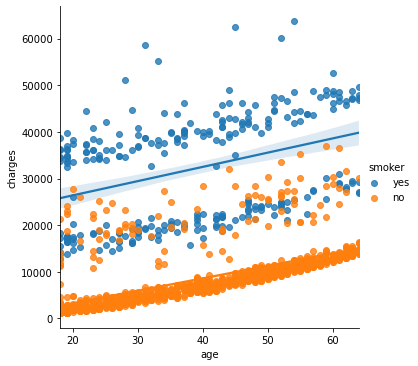

In [9]:
sns.lmplot(x="age", y="charges", hue="smoker", data=df)

Podemos observar cómo los charges aumenta a medida que aumenta la edad, y también teniendo en cuenta si la persona es fumadora o no.

In [10]:
# Definimos las columnas a transformar
cat_cols = ['smoker']
numeric_cols = ['age', 'bmi']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['charges']), df['charges'], test_size=0.30)

# Definimos el column transformer, donde se eliminan las columnas que no nos nteresan
# y se transforman las que nos interesan
pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[('drop_columns', 'drop', ['region',
                                                                        'sex',
                                                                        'children'
                                                                       ]),
                                              ('onehot', OneHotEncoder(), cat_cols),
                                              ('scaler', StandardScaler(), numeric_cols)])


pipeline = Pipeline([
    ('pre_processing', pre_process),
    ("RandomForestRegressor", RandomForestRegressor())
])

Ya tenemos definido nuestro pipeline, hagamos una predicción.

In [11]:
pipeline.fit(X_train, y_train)
Y_train_pred = pipeline.predict(X_train)

In [12]:
r2_score = metrics.r2_score(y_train, Y_train_pred)
r2_score

0.9695077019957905

In [13]:
mse_lr = metrics.mean_squared_error(y_train, Y_train_pred)
mse_lr

4435792.474264685

Hemos obtenido un buen valor de R2. 
Ahora usemos GridSearchCV para obtener el mejor valor para la profundidad del algoritmo.

In [14]:
param_random = {
    "RandomForestRegressor__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "RandomForestRegressor__min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

search = GridSearchCV(pipeline, param_random)
search.fit(X_train, y_train)
print(search.best_params_)

{'RandomForestRegressor__max_depth': 4, 'RandomForestRegressor__min_samples_split': 3}


Obtuvimos que los mejores parametros con un max_depth de 4 y un min_samples_split de 3

## Exercici 2

Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ale\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ale\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ale\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ale\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Separamos las palabras.

In [16]:
text= 'Python is meant to be an easily readable language. Its formatting is visually uncluttered, and it often uses English keywords where other languages use punctuation. Unlike many other languages, it does not use curly brackets to delimit blocks, and semicolons after statements are allowed but are rare.'
tokenized_text=word_tokenize(text)
tokenized_text

['Python',
 'is',
 'meant',
 'to',
 'be',
 'an',
 'easily',
 'readable',
 'language',
 '.',
 'Its',
 'formatting',
 'is',
 'visually',
 'uncluttered',
 ',',
 'and',
 'it',
 'often',
 'uses',
 'English',
 'keywords',
 'where',
 'other',
 'languages',
 'use',
 'punctuation',
 '.',
 'Unlike',
 'many',
 'other',
 'languages',
 ',',
 'it',
 'does',
 'not',
 'use',
 'curly',
 'brackets',
 'to',
 'delimit',
 'blocks',
 ',',
 'and',
 'semicolons',
 'after',
 'statements',
 'are',
 'allowed',
 'but',
 'are',
 'rare',
 '.']

Calculamos la frecuencia de cada palabra.

In [17]:
fdist = FreqDist(tokenized_text)
fdist

FreqDist({'.': 3, ',': 3, 'is': 2, 'to': 2, 'and': 2, 'it': 2, 'other': 2, 'languages': 2, 'use': 2, 'are': 2, ...})

Veamos las frecuencias en un gráfico.

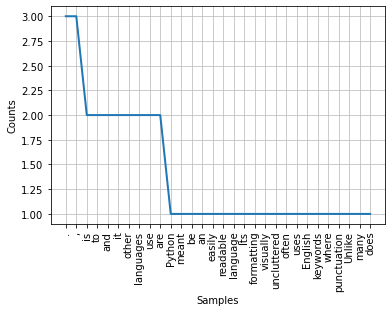

In [18]:
fdist.plot(30, cumulative=False)
plt.show()

Lo que más se repite es el punto, y luego la coma.

## Nivel 2 - Exercici 1

Treu les stopwords i realitza stemming al teu conjunt de dades.

Quitaremos las stop words del listado de token

In [19]:
filtered_sent=[]
for w in tokenized_text:
    if w not in set(stopwords.words('english')):
        filtered_sent.append(w)
        
print("Tokenized Sentence:", tokenized_text)

Tokenized Sentence: ['Python', 'is', 'meant', 'to', 'be', 'an', 'easily', 'readable', 'language', '.', 'Its', 'formatting', 'is', 'visually', 'uncluttered', ',', 'and', 'it', 'often', 'uses', 'English', 'keywords', 'where', 'other', 'languages', 'use', 'punctuation', '.', 'Unlike', 'many', 'other', 'languages', ',', 'it', 'does', 'not', 'use', 'curly', 'brackets', 'to', 'delimit', 'blocks', ',', 'and', 'semicolons', 'after', 'statements', 'are', 'allowed', 'but', 'are', 'rare', '.']


In [20]:
print("Filterd Sentence:", filtered_sent)

Filterd Sentence: ['Python', 'meant', 'easily', 'readable', 'language', '.', 'Its', 'formatting', 'visually', 'uncluttered', ',', 'often', 'uses', 'English', 'keywords', 'languages', 'use', 'punctuation', '.', 'Unlike', 'many', 'languages', ',', 'use', 'curly', 'brackets', 'delimit', 'blocks', ',', 'semicolons', 'statements', 'allowed', 'rare', '.']


Ahora podemos hacer el Stemming analisis

In [21]:
lem = WordNetLemmatizer()
ps = PorterStemmer()

stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

In [22]:
print("Stemmed Sentence:", stemmed_words)

Stemmed Sentence: ['python', 'meant', 'easili', 'readabl', 'languag', '.', 'it', 'format', 'visual', 'unclutt', ',', 'often', 'use', 'english', 'keyword', 'languag', 'use', 'punctuat', '.', 'unlik', 'mani', 'languag', ',', 'use', 'curli', 'bracket', 'delimit', 'block', ',', 'semicolon', 'statement', 'allow', 'rare', '.']


Podemos ver como se han modificado algunas palabras.

## Nivel 3 - Exercici 1

Realitza sentiment analysis al teu conjunt de dades.

Crearemos un dataframe con textos para realizar nuestro análisis.

In [23]:
lista = [{'text':'Python is better than Java'}, {'text':'Java is a slow language'},{'text':'He is not better than him'}, {'text':'He was called'}, {'text':'You are the best'}]
dataframe = pd.DataFrame(lista)
dataframe.head()

,text
0,Python is better than Java
1,Java is a slow language
2,He is not better than him
3,He was called
4,You are the best


In [24]:
# creamos un metodo para mapear los POS tag porque luego utilizaremos WordNetLemmatizer para aplicar
# Lemmatization
def get_pos_letter(pos):
    if pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('N'):
        return wordnet.NOUN
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return None 
        
def token_stop_pos(text):
    stops = set(stopwords.words('english'))
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in stops:
            newlist.append(tuple([word, get_pos_letter(tag)]))
    return newlist

dataframe['pos_tag'] = dataframe['text'].apply(token_stop_pos)
dataframe.head()

,text,pos_tag
0,Python is better than Java,"[(Python, n), (better, a), (Java, n)]"
1,Java is a slow language,"[(Java, n), (slow, a), (language, n)]"
2,He is not better than him,"[(better, r)]"
3,He was called,"[(called, v)]"
4,You are the best,"[(best, a)]"


Ahora aplicaremos análisis lemma

In [25]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_sentence = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_sentence = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_sentence = lemma_sentence + " " + lemma
    return lemma_sentence

dataframe['lemma'] = dataframe['pos_tag'].apply(lemmatize)
dataframe.head()

,text,pos_tag,lemma
0,Python is better than Java,"[(Python, n), (better, a), (Java, n)]",Python good Java
1,Java is a slow language,"[(Java, n), (slow, a), (language, n)]",Java slow language
2,He is not better than him,"[(better, r)]",well
3,He was called,"[(called, v)]",call
4,You are the best,"[(best, a)]",best


Podemos ver como se modificaron algunas palabras como called a call, o better a good

Ahora podemos aplicar el Sentiment Analysis, utilizaremos TextBlob para clasificar los textos.

In [27]:
def get_subjectivity(review):
    return TextBlob(review).sentiment.subjectivity

def get_polarity(review):
    return TextBlob(review).sentiment.polarity

def get_analysis(score):
    if score < 0:
        return 'Negativa'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positiva'
    
dataframe['subjectivity'] = dataframe['lemma'].apply(get_subjectivity) 
dataframe['polarity'] = dataframe['lemma'].apply(get_polarity) 
dataframe['analisis'] = dataframe['polarity'].apply(get_analysis)
dataframe.head()

,text,pos_tag,lemma,subjectivity,polarity,analisis
0,Python is better than Java,"[(Python, n), (better, a), (Java, n)]",Python good Java,0.60,0.70,Positiva
1,Java is a slow language,"[(Java, n), (slow, a), (language, n)]",Java slow language,0.40,-0.30,Negativa
2,He is not better than him,"[(better, r)]",well,0.00,0.00,Neutral
3,He was called,"[(called, v)]",call,0.00,0.00,Neutral
4,You are the best,"[(best, a)]",best,0.30,1.00,Positiva


Podemos ver como se ha hecho el analisis correctamente clasificando el texto 'Python is better than Java' como un texto positivo y 'Java is a slow language' como negativa.